In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utility Functions and Class Definitions

In [ ]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 8.5 MB/s 


In [ ]:
import numpy as np
import keras
from PIL import Image
import os 
import glob
import cv2
from keras.preprocessing import image
import numpy as np
from natsort import natsorted, ns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from PIL import Image
import cv2
import numpy as np
import keras
from PIL import Image
import cv2
from keras.models import load_model
from keras import backend as K
from sklearn import metrics as m
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from mpl_toolkits.axes_grid1 import ImageGrid

path_org = 'drive/MyDrive/ML PROJECT/full_org'
path_frog = 'drive/MyDrive/ML PROJECT/full_forg'
sns.set_style('darkgrid')

Using TensorFlow backend.


In [ ]:
def get_dataframe():
  forg_images=[]
  for indis in range(1,56):
    if(indis==41):
      continue
    else:
        for j in range(1,25):
            path=(path_frog+'/forgeries_'+str(indis)+'_'+str(j)+'.png')
            forg_images.append(path)
      
    
  org_images=[]
  for indis in range(1,56):
    if(indis==41):
      continue
    else:
      for j in range(1,25):
          path=(path_org+'/original_'+str(indis)+'_'+str(j)+'.png')
          org_images.append(path)  

  no_of_ppl = len(org_images)//24 
  
  raw_data = {"sing_1":[], "sign_2":[], "label":[]}
  
  for i in range(no_of_ppl):
    i1_batch_1 = []
    i1_batch_2 = []
    i2_batch = []

    start = i*24
    end = (i+1)*24
    
    for j in range(start,end): 
      i1_batch_1.append(org_images[j])
      i1_batch_2.append(org_images[j])
      raw_data["label"].append(1)#0

    temp_rot = (i1_batch_1[-12:]+i1_batch_1[:-12])
    i1_batch_1.extend(i1_batch_2)

    for elem in temp_rot:
      i2_batch.append(elem)

    for j in range(start,end): 
      i2_batch.append(forg_images[j])
      raw_data["label"].append(0)#1

    raw_data["sing_1"].extend(i1_batch_1)
    raw_data["sign_2"].extend(i2_batch)
  df = pd.DataFrame(raw_data, columns = ["sing_1","sign_2","label"])
  df=df.reindex(df.index)
  return df

def get_dataset():
  df = get_dataframe() 
  train_set, val_set = train_test_split(df,test_size=0.3,random_state=0)
  return train_set, val_set


In [ ]:
class SignatureSequence(keras.utils.Sequence):
    
    def __init__(self, df, batch_size, dim):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]
        
        self.on_epoch_end()

    def __len__(self):
        s_df=self.df.shape[0]
        n=np.floor(s_df/self.batch_size)
        return int(n)

    def __getitem__(self, indis):
         #indexes
        batches = self.indises[indis*self.batch_size:(indis+1)*self.batch_size]
        items = [self.df.iloc[k] for k in batches]
        part1,part2 = self.generator(items)
        return part1,part2

    def on_epoch_end(self):
        self.indises = np.arange(self.df.shape[0])
        

    def generator(self, items):
        part_1 = np.empty((self.batch_size, *self.dim,1))
        part_2 = np.empty((self.batch_size, *self.dim,1))
        label = np.empty((self.batch_size), dtype=int)
        
        for i in range(len(items)):
            #image 1
            signature_1 = cv2.imread(items[i]["sing_1"])
           
            resized_signature = cv2.resize(signature_1,(220,155))
            gray_signature=cv2.cvtColor(resized_signature, cv2.COLOR_BGR2GRAY)
            ret,thr_img = cv2.threshold(gray_signature, 0, 255, cv2.THRESH_OTSU)
            normalized_signature=thr_img/255
            signature_expanded = normalized_signature[:, :, np.newaxis]
            signature_1=np.array(signature_expanded)

            #image 2
            signature_2 = cv2.imread(items[i]["sign_2"])
            
            resized_signature = cv2.resize(signature_2,(220,155))
            gray_signature=cv2.cvtColor(resized_signature, cv2.COLOR_BGR2GRAY)
            ret,thr_img = cv2.threshold(gray_signature, 0, 255, cv2.THRESH_OTSU)
            normalized_signature=thr_img/255
            signature_expanded = normalized_signature[:, :, np.newaxis]
            signature_2=np.array(signature_expanded)
            

            label[i] = items[i]["label"]
            part_1[i,] = signature_1
            part_2[i,] = signature_2 

        return [part_1 ,part_2], label


In [ ]:
def contrastive_loss(l, y_pred):
    margin = 1
    margin_square = (K.maximum(margin - y_pred, 0))**2
    return K.mean((l * (y_pred)**2)*l + (1 - l)* margin_square)


In [ ]:
def accuracy_hesapla(y_pred, y_true):
    # Compute ROC accuracy with a range of thresholds on distances.
    df_max = np.max(y_pred)
    df_min = np.min(y_pred)
    number_of_sim = np.sum(y_true == 1)
    number_of_diff = np.sum(y_true == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh=0
    
    true_pos_rate_list=[]
    for distance in np.arange(df_min, df_max+step, step):
        idx1 = y_pred.ravel() <= distance
        idx2 = y_pred.ravel() > distance
       
        true_pos_rate = float(np.sum(y_true[idx1] == 1)) / number_of_sim
        true_neg_rate  = float(np.sum(y_true[idx2] == 0)) / number_of_diff
        acc = 0.5 * (true_pos_rate + true_neg_rate )        
        
        true_pos_rate_list.append(true_pos_rate)
        if (acc > max_acc):
            max_acc, best_thresh = acc, distance
           
    return max_acc, best_thresh,true_pos_rate_list

In [ ]:
def preprocess_image(img):
    resized_signature = cv2.resize(img,(220,155),cv2.IMREAD_GRAYSCALE)
    gray_signature=cv2.cvtColor(resized_signature, cv2.COLOR_BGR2GRAY)
    ret,thr_img = cv2.threshold(gray_signature, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    normalized_signature=thr_img/255
    signature_expanded = normalized_signature[:, :, np.newaxis]
    # plt.imshow(resized_signature)
    fig = plt.figure(figsize=(4,4 ))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    lst = [resized_signature]

    for ax, im in zip(grid, lst):
      ax.imshow(im)

    return signature_expanded

## Testing And Performance Evaluation 

In [ ]:
ds_train,ds_val = get_dataset()
img_width= 155
img_height = 220
dim=(img_width,img_height)
batch_size=64
train_datagen = SignatureSequence(ds_train,batch_size,dim)
validation_datagen = SignatureSequence(ds_val,batch_size,dim)
print("Test Dataset: ")
ds_labels=validation_datagen.labels[0:768]
print("Number of Instances: "+str(len(ds_labels)))


Test Dataset: 
Number of Instances: 768


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)




PERFORMANCE OF MODEL ON TESTING DATA
Best Threshold:0.713634087042883

Confusion Matrix:
 [[353  33]
 [ 58 324]]





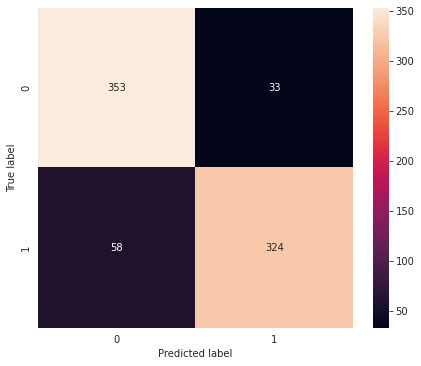



Accuracy 0.8815104166666666


Classification Report
               precision    recall  f1-score   support

           0       0.86      0.91      0.89       386
           1       0.91      0.85      0.88       382

    accuracy                           0.88       768
   macro avg       0.88      0.88      0.88       768
weighted avg       0.88      0.88      0.88       768



In [ ]:
model= load_model('./drive/MyDrive/ML PROJECT/Offline_Sign_model.h5',custom_objects={'contrastive_loss':contrastive_loss})
y_pred = model.predict_generator(validation_datagen)#, steps=25
ds_labels=validation_datagen.labels[0:768]

print("\n\nPERFORMANCE OF MODEL ON TESTING DATA")
max_acc,threshold,tpr_list=accuracy_hesapla(y_pred,ds_labels)

print("Best Threshold:"+str(threshold))

from sklearn import metrics as m
confusionmatrix = m.confusion_matrix(ds_labels, y_pred <threshold)
print("\nConfusion Matrix:\n", confusionmatrix)


print("\n\n")

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(6, 5))
sns.heatmap(confusionmatrix, annot=True, fmt="d")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('\n\nAccuracy', m.accuracy_score(ds_labels, y_pred < threshold))
from sklearn.metrics import classification_report
print('\n\nClassification Report\n',classification_report(ds_labels, y_pred <threshold))


# Model Demo

In [ ]:
model= load_model('./drive/MyDrive/ML PROJECT/Offline_Sign_model.h5',custom_objects={'contrastive_loss':contrastive_loss})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [ ]:
from google.colab import files
upload_1 = files.upload()
upload_2 = files.upload()

Saving sign_2.jpeg to sign_2 (2).jpeg


Saving sign_1.jpeg to sign_1.jpeg


Predicted Y Value:  [[2.954419]]
Rounded Predicted Y Value:  [[3.]]
The second signature is forged 



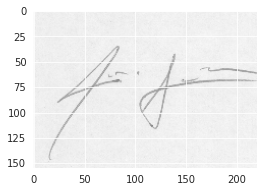

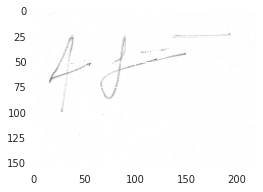

In [ ]:
# img1 = cv2.imread(list(upload_1.keys())[0])
# img2 = cv2.imread(list(upload_2.keys())[0]) 

img1 = cv2.imread('drive/MyDrive/ML PROJECT/full_org/original_1_22.png')
img2 = cv2.imread('drive/MyDrive/ML PROJECT/full_forg/forgeries_1_24.png')
pre_image=preprocess_image(img1)
pre_image2=preprocess_image(img2)
        
img_1=np.expand_dims(pre_image,axis=0)
img_2=np.expand_dims(pre_image2,axis=0)

y_pred = model.predict([img_1,img_2])
print("Predicted Y Value: ", y_pred)

y1=(np.round(y_pred))
print("Rounded Predicted Y Value: ", y1)
if (y1[0][0] == 0):
  print('The second signature is genuine \n')
      
elif(y1[0][0]>=1):
  print('The second signature is forged \n')